# Phase Scatter Plots for Classifying Snow Drought as Temperature or Precipitation Driven

In [2]:
from imports import *
from netCDF4 import Dataset # for saving netcdfs 
from cartopy.feature import ShapelyFeature # for plotting HUC2 regions
from cartopy.io.shapereader import Reader
from joblib import Parallel, delayed
import scipy.stats as st # for easy confidence intervals using student-t
import math

# axes grid for 
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
from shapely.ops import cascaded_union # for uncertainty cones


states = cfeature.NaturalEarthFeature(category='cultural',
                                     name='admin_1_states_provinces_shp',
                                     scale='50m',
                                     facecolor='none',
                                     edgecolor='black',
                                     linewidth=1)
def is_winter(month):
    return (month <=4) | (month >=10)
mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")

In [4]:
# load mask and sample ensemble member

rootdir = "/work/Julian.Schmitt/data/zscores/snowi/"
snowi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/hist/hist_monthly_ens_01.nc")
snowi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/future/future_monthly_ens_01.nc")
snowi = xr.concat([snowi_hist, snowi_future], dim='time').sortby('time')

# corresponding precip 
precipi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/precipi/hist/hist_monthly_ens_01.nc")
precipi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/precipi/future/future_monthly_ens_01.nc")
precipi = xr.concat([precipi_hist, precipi_future], dim='time').sortby('time')

# corresponding temp
tempi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/tempi/hist/hist_monthly_ens_01.nc")
tempi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/tempi/future/future_monthly_ens_01.nc")
tempi = xr.concat([tempi_hist, tempi_future], dim='time').sortby('time')

In [8]:
# select decade samples
t = slice("1990", "1999")
snow_decade = snowi.sel(time=t)
precip_decade = precipi.sel(time=t)
temp_decade = tempi.sel(time=t)

In [9]:
snow_processed = snow_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                        snow_decade.time})>20).sel(time=is_winter(snow_decade['time.month']))
precip_processed = precip_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                        precip_decade.time})>20).sel(time=is_winter(precip_decade['time.month']))
temp_processed = temp_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                        temp_decade.time})>20).sel(time=is_winter(temp_decade['time.month']))

In [10]:
snow_ar = snow_processed.snow.values.ravel()
precip_ar = precip_processed.snow.values.ravel()
temp_ar = temp_processed.snow.values.ravel()

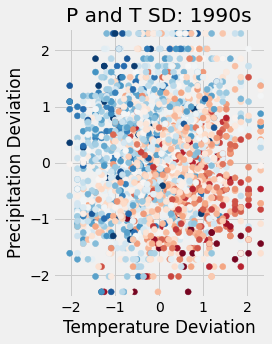

In [70]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(4,5))
from matplotlib import cm
#plt.style.use("default")
# select 1000 data points randomly
norm = matplotlib.colors.Normalize(vmin=-2.4, vmax = -1.3)
cleaned_indices = snow_ar < -1.3
samp = random.sample(population=range(len(temp_ar)), k=5000)
drought_cm = matplotlib.cm.get_cmap('RdBu')


te, pr, sn = temp_ar[samp], precip_ar[samp], snow_ar[samp]
plt.scatter(te, pr, c=sn, cmap=drought_cm, vmin=-2.4, vmax=2.4)
# plt.scatter(np.nanmean(temp_ar), np.nanmean(precip_ar), 
#             color=cm.Reds_r(norm(np.nanmean(snow_ar))),s=300, edgecolor='k', linewidth=3)

# te, pr, sn = temp_ar[cleaned_indices][samp], precip_ar[cleaned_indices][samp], snow_ar[cleaned_indices][samp]
# plt.scatter(te, pr, c=sn, cmap=drought_cm, vmin=-2.4, vmax=-1.3)
# plt.scatter(np.nanmean(temp_ar[cleaned_indices]), np.nanmean(precip_ar[cleaned_indices]), 
#             color=cm.Reds_r(norm(np.nanmean(snow_ar[cleaned_indices]))),s=300, edgecolor='k', linewidth=3)

plt.title("P and T SD: 1990s")
plt.xlabel("Temperature Deviation")
plt.ylabel("Precipitation Deviation");
plt.xlim((-2.4,2.4))
plt.ylim((-2.4, 2.4))
plt.tight_layout()
#plt.colorbar(label="SWE Deviation");
plt.savefig("/home/Julian.Schmitt/plots/pt_all_90s.png", dpi=200)

In [36]:
np.nanmean(temp_ar), np.nanmean(precip_ar), np.nanmean(snow_ar)

(-0.0014982554, 0.06349787, 0.04988024)

In [55]:
def samp_decade(snow_ds, temp_ds, precip_ds, mask_ds, decade, k, drought_threshold: float =-1.3):
    """Gets sample points for scatterplots"""
    
    # select time ranges
    snow_decade = snow_ds.sel(time=slice(decade[0], decade[1]))
    precip_decade = precip_ds.sel(time=slice(decade[0], decade[1]))
    temp_decade = temp_ds.sel(time=slice(decade[0], decade[1]))
    
    # mask to only snowy cells, select only winter months
    snow_processed = snow_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                        snow_decade.time})>20).sel(time=is_winter(snow_decade['time.month']))
    precip_processed = precip_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                            precip_decade.time})>20).sel(time=is_winter(precip_decade['time.month']))
    temp_processed = temp_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                            temp_decade.time})>20).sel(time=is_winter(temp_decade['time.month']))
    
    # ravel values
    snow_ar = snow_processed.snow.values.ravel()
    precip_ar = precip_processed.snow.values.ravel()
    temp_ar = temp_processed.snow.values.ravel()
    
    # remove nans - keeps order as mask is identical
    snow_ar = snow_ar[~np.isnan(snow_ar)]
    precip_ar = precip_ar[~np.isnan(precip_ar)]
    temp_ar = temp_ar[~np.isnan(temp_ar)]
    
    # select drought months
    sd_index = snow_ar < drought_threshold # index
    snow_ar = snow_ar[sd_index]
    precip_ar = precip_ar[sd_index]
    temp_ar = temp_ar[sd_index]
    
    # select random sample and return 
    samp = None
    k_val = k
    while samp is None:
        try:
            samp = random.sample(population = range(len(temp_ar[~np.isnan(temp_ar)])), k=int(k_val))
        except ValueError:
            k_val = float(k_val)/2
            pass
    
    snow_samp = snow_ar[samp]
    precip_samp = precip_ar[samp]
    temp_samp = temp_ar[samp]
    
    
    return snow_samp, precip_samp, temp_samp

In [50]:
# run sample later file 
s, p, t = samp_decade(snowi, tempi, precipi, mask_ds, ["2080", "2089"], 2000)


2000 <class 'int'>


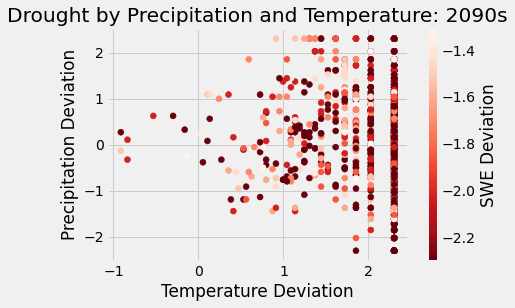

In [51]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")
# select 1000 data points randomly
drought_cm = matplotlib.cm.get_cmap('Reds_r')
plt.scatter(t, p, c=s, cmap=drought_cm)
plt.title("Drought by Precipitation and Temperature: 2090s")
plt.xlabel("Temperature Deviation")
plt.ylabel("Precipitation Deviation")
plt.colorbar(label="SWE Deviation");

In [52]:
#(mask_ds.snow > 20).values.ravel()
len(temp_ar[samp][~np.isnan(temp_ar[samp])])

1910

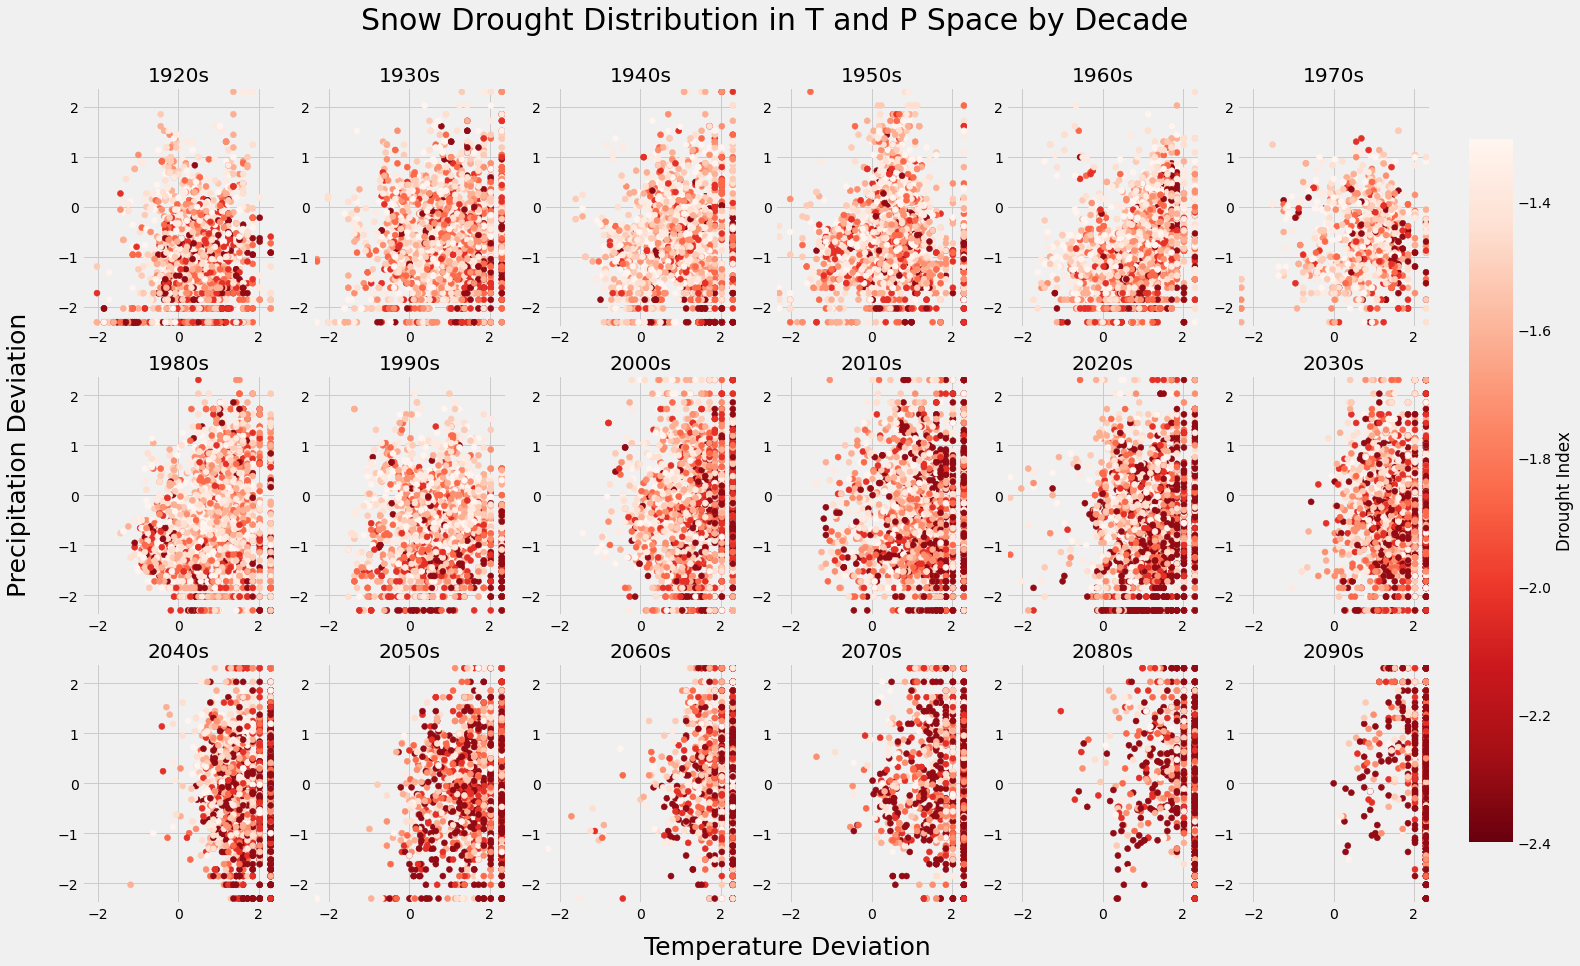

In [56]:
# get decade strings for slicing datasets
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]

# make plot
fig, ax = plt.subplots(3, 6, figsize=(26,14))

ax = ax.ravel()

for ind, decade in enumerate(decades):
    # get snow, precip, and temp samples
    s, p, t = samp_decade(snowi, tempi, precipi, mask_ds, decade, 2000) # 2k samples
    im = ax[ind].scatter(t, p, c=s, cmap=drought_cm, vmin=-2.4, vmax=-1.3)
    ax[ind].set_title(f"{decade[0]}s")
    ax[ind].set_xlim((-2.4,2.4))
    ax[ind].set_ylim((-2.4, 2.4))
    #plt.colorbar(label="SWE Deviation");
    
# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.13, 0.025, 0.7])
fig.colorbar(im, cax = cbar_ax, label="Drought Index")
fig.suptitle("Snow Drought Distribution in T and P Space by Decade", x=0.45, y=0.96, fontsize=30);
fig.text(0.38, 0.02, "Temperature Deviation", fontsize=25);
plt.xlabel("")
fig.text(0.04, 0.38, "Precipitation Deviation", fontsize=25, rotation = 90);
fig.savefig("/home/Julian.Schmitt/plots/Drought_1.3_distribution_T_and_P_decadal_ens01.png", dpi=300)

## Phase Diagrams
"In all the phase diagrams, I envision temperature drought along one axis and precipitation drought along the other axis. The units are standardized so that temperature and precipitation units are directly comparable (1 = 1 standard deviation for both variables), like what you already suggested. For the trajectory plot, the time step would be the same as for the individual phase diagrams. For example, if you make plots for every decade, then the time step for the trajectory plot would be 10 years." - Nat

In [89]:
decadal_snow, decadal_precip, decadal_temp = [], [], []
for ind, decade in enumerate(decades):
    # get snow, precip, and temp samples
    s, p, t = samp_decade(snowi, tempi, precipi, mask_ds, decade, 2000) # 2k samples
    
    # aggregate - first pass we just take the average
    decadal_snow.append(np.mean(s))
    decadal_precip.append(np.mean(p))
    decadal_temp.append(np.mean(t))

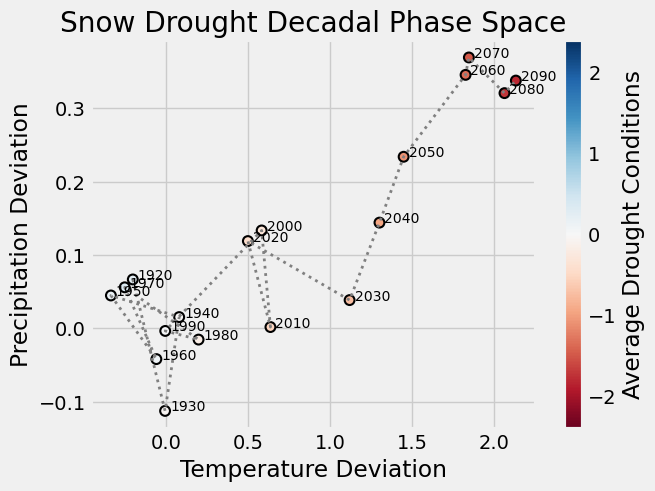

In [121]:
# make phase diagram 
plt.plot(decadal_temp,decadal_precip, color='grey', linestyle='dotted', linewidth=2)
plt.scatter(decadal_temp, decadal_precip, c=decadal_snow, s=50, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='k', linewidths=1.5)

# add annotations
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    plt.annotate(txt, (decadal_temp[i]+0.03, decadal_precip[i]), fontsize=10)
    

plt.xlabel("Temperature Deviation")
plt.ylabel("Precipitation Deviation")
plt.title("Snow Drought Decadal Phase Space")
plt.colorbar(im, label="Average Drought Conditions");

## Make Phase Diagrams with Uncertainty "Cone"
Increase the sampling rate and run across all ensemble members - for these we don't need to take a sample and can just include all snowy regions as our uncertainty can come from the ensemble spread. 

In [3]:
def decadal_mean(ens_number, decade_center, drought_threshold:float=-1.3,
                     mask_ds: any=mask_ds,future_scenario: str="future"):
    """Takes ensemble member number. Gets all points from decade, returns average for ensemble member"""
    
    # file reading
    snowi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/"
                                   f"hist/hist_monthly_ens_{ens_number}.nc")
    snowi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/"
                                   f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    snowi = xr.concat([snowi_hist, snowi_future], dim='time').sortby('time')

    # corresponding precip 
    precipi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/precipi/"
                                     f"hist/hist_monthly_ens_{ens_number}.nc")
    precipi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/precipi/"
                                     f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    precipi = xr.concat([precipi_hist, precipi_future], dim='time').sortby('time')

    # corresponding temp
    tempi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/tempi/"
                                   f"hist/hist_monthly_ens_{ens_number}.nc")
    tempi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/tempi/"
                                   f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    tempi = xr.concat([tempi_hist, tempi_future], dim='time').sortby('time')
    
    # select time ranges
    decade = (str(decade_center-5), str(decade_center+4))
    snow_decade = snowi.sel(time=slice(decade[0], decade[1]))
    precip_decade = precipi.sel(time=slice(decade[0], decade[1]))
    temp_decade = tempi.sel(time=slice(decade[0], decade[1]))
    
    # mask to only snowy cells, select only winter months
    snow_processed = snow_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                        snow_decade.time})>20).sel(time=is_winter(snow_decade['time.month']))
    precip_processed = precip_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                            precip_decade.time})>20).sel(time=is_winter(precip_decade['time.month']))
    temp_processed = temp_decade.zscores.where(mask_ds.expand_dims(dim={'time':
                                            temp_decade.time})>20).sel(time=is_winter(temp_decade['time.month']))
    
    # ravel values
    snow_ar = snow_processed.snow.values.ravel()
    precip_ar = precip_processed.snow.values.ravel()
    temp_ar = temp_processed.snow.values.ravel()
    
    # remove nans - keeps order as mask is identical
    snow_ar = snow_ar[~np.isnan(snow_ar)]
    precip_ar = precip_ar[~np.isnan(precip_ar)]
    temp_ar = temp_ar[~np.isnan(temp_ar)]
    
    # select drought months
    sd_index = snow_ar < drought_threshold # index
    snow_ar = snow_ar[sd_index]
    precip_ar = precip_ar[sd_index]
    temp_ar = temp_ar[sd_index]
    
    return np.mean(snow_ar), np.mean(precip_ar), np.mean(temp_ar)

In [71]:
def decadal_mean(ens_number, decade_centers, drought_threshold:float=-1.3,
                     mask_ds: any=mask_ds,future_scenario: str="future"):
    """Takes ensemble member number. Gets all points from decade, returns average for ensemble member
        Set drought_threshold=2.5 if you want to look at all points. 
    """
    
    # file reading
    snowi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/"
                                   f"hist/hist_monthly_ens_{ens_number}.nc")
    snowi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/"
                                   f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    snowi = xr.concat([snowi_hist, snowi_future], dim='time').sortby('time')

    # corresponding precip 
    precipi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/precipi/"
                                     f"hist/hist_monthly_ens_{ens_number}.nc")
    precipi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/precipi/"
                                     f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    precipi = xr.concat([precipi_hist, precipi_future], dim='time').sortby('time')

    # corresponding temp
    tempi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/tempi/"
                                   f"hist/hist_monthly_ens_{ens_number}.nc")
    tempi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/tempi/"
                                   f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    tempi = xr.concat([tempi_hist, tempi_future], dim='time').sortby('time')
    
    # mask to only snowy cells, select only winter months
    mask20 = mask_ds.expand_dims(dim={'time': snowi.time}) > 20
    snow_sel = snowi.zscores.where(mask20).sel(time=is_winter(snowi['time.month']))
    precip_sel = precipi.zscores.where(mask20).sel(time=is_winter(precipi['time.month']))
    temp_sel = tempi.zscores.where(mask20).sel(time=is_winter(tempi['time.month']))
    
    snow_means, precip_means, temp_means = [], [], []
    for decade_center in decade_centers:
        
        # select time ranges
        decade = (str(decade_center-5), str(decade_center+4))
        snow_decade = snow_sel.sel(time=slice(decade[0], decade[1]))
        precip_decade = precip_sel.sel(time=slice(decade[0], decade[1]))
        temp_decade = temp_sel.sel(time=slice(decade[0], decade[1]))

        # ravel values
        snow_ar = snow_decade.snow.values.ravel()
        precip_ar = precip_decade.snow.values.ravel()
        temp_ar = temp_decade.snow.values.ravel()

        # remove nans - keeps order as mask is identical
        snow_ar = snow_ar[~np.isnan(snow_ar)]
        precip_ar = precip_ar[~np.isnan(precip_ar)]
        temp_ar = temp_ar[~np.isnan(temp_ar)]

        # select drought months
        sd_index = snow_ar < drought_threshold # index
        snow_ar = snow_ar[sd_index]
        precip_ar = precip_ar[sd_index]
        temp_ar = temp_ar[sd_index]
        
        # append mean decadal climatology 
        snow_means.append(np.mean(snow_ar))
        precip_means.append(np.mean(precip_ar))
        temp_means.append(np.mean(temp_ar))
    
    return snow_means, precip_means, temp_means

def uncertainty_cone(means_ar, times, alpha):
    """Takes array of ensemble member arrays of decadal snow, precip, and temp means.
         - Returns shapely cone of uncertainty for plotting
    """
    snow_means, prec_means, temp_means = [], [], []
    snow_cis, prec_cis, temp_cis = [], [], []
    # loop through decades
    for ind, decade in enumerate(times):
        # extract snow, precip, temp values for all ensemble members for specific decade
        snow_val_dec = [means_ar[i][0][ind] for i in range(30)]
        prec_val_dec = [means_ar[i][1][ind] for i in range(30)]
        temp_val_dec = [means_ar[i][2][ind] for i in range(30)]

        # get means and CIs
        snow_mean, prec_mean, temp_mean = np.mean(snow_val_dec), np.mean(prec_val_dec), np.mean(temp_val_dec)
        CI_prec = st.t.interval(alpha=alpha, df = len(prec_val_dec)-1, loc= prec_mean, scale=st.sem(prec_val_dec))
        CI_temp = st.t.interval(alpha= alpha, df = len(temp_val_dec)-1, loc= temp_mean, scale=st.sem(temp_val_dec))

        # append to list of vals
        snow_means.append(snow_mean)
        prec_means.append(prec_mean)
        temp_means.append(temp_mean)

        prec_cis.append(CI_prec)
        temp_cis.append(CI_temp)
    
    # get CI radii
    prec_radii = np.array([p[1]-p[0] for p in prec_cis])/2 # divide by 2 to get radius
    temp_radii = np.array([t[1]-t[0] for t in temp_cis])/2

    # get ellipses from ensemble mean and CI radii
    thetas = np.linspace(0, 2 * np.pi, 360) # nice fine resolution
    temp_means, prec_means = np.array(temp_means), np.array(prec_means)
    polygon_x = temp_means[:,None] + temp_radii[:,None] * np.sin(thetas)
    polygon_y = prec_means[:,None] + prec_radii[:,None] * np.cos(thetas)

    # make ellipses points into shapely polygon objects
    ps = [Polygon(i) for i in np.dstack((polygon_x, polygon_y))]

    # list of convex hulls of subsequent circles
    n = range(len(ps)-1)
    convex_hulls = [MultiPolygon([ps[i], ps[i+1]]).convex_hull for i in n]

    # Concat to get cone of uncertainty
    cone = cascaded_union(convex_hulls)
    return snow_means, prec_means, temp_means, cone

In [72]:
%%time 
# compute all means for RCP8.5
times = np.arange(1925, 2100, 10)
ncores = os.cpu_count() # use all available cores
all_means = Parallel(n_jobs=ncores)(delayed(decadal_mean)(str(i).zfill(2), times) for i in range(1,31))
all_means245 = Parallel(n_jobs=ncores)(delayed(decadal_mean)(str(i).zfill(2), times, -1.3, mask_ds, "future245") 
                                       for i in range(1,31))

CPU times: user 293 ms, sys: 128 ms, total: 421 ms
Wall time: 24.2 s


In [73]:
# generate uncertainty cones for RCP 4.5 and 8.5 values
snow_mean45, prec_mean45, temp_mean45, cone_45 = uncertainty_cone(all_means245, times, 0.95)
snow_mean85, prec_mean85, temp_mean85, cone_85 = uncertainty_cone(all_means, times, 0.95)

In [74]:
# compute means and uncertainty cones for all drought events
all_clim_means85 = Parallel(n_jobs=ncores)(delayed(decadal_mean)(str(i).zfill(2), times, 2.5, mask_ds, "future")
                                         for i in range(1,31))
all_clim_means45 = Parallel(n_jobs=ncores)(delayed(decadal_mean)(str(i).zfill(2), times, 2.5, mask_ds, 
                                                                  "future245") for i in range(1,31))

# generate uncertainty cones for RCP 4.5 and 8.5 values
clim_snow_m45, clim_prec_m45, clim_temp_m45, clim_cone_45 = uncertainty_cone(all_clim_means45, times, 0.95)
clim_snow_m85, clim_prec_m85, clim_temp_m85, clim_cone_85 = uncertainty_cone(all_clim_means85, times, 0.95)

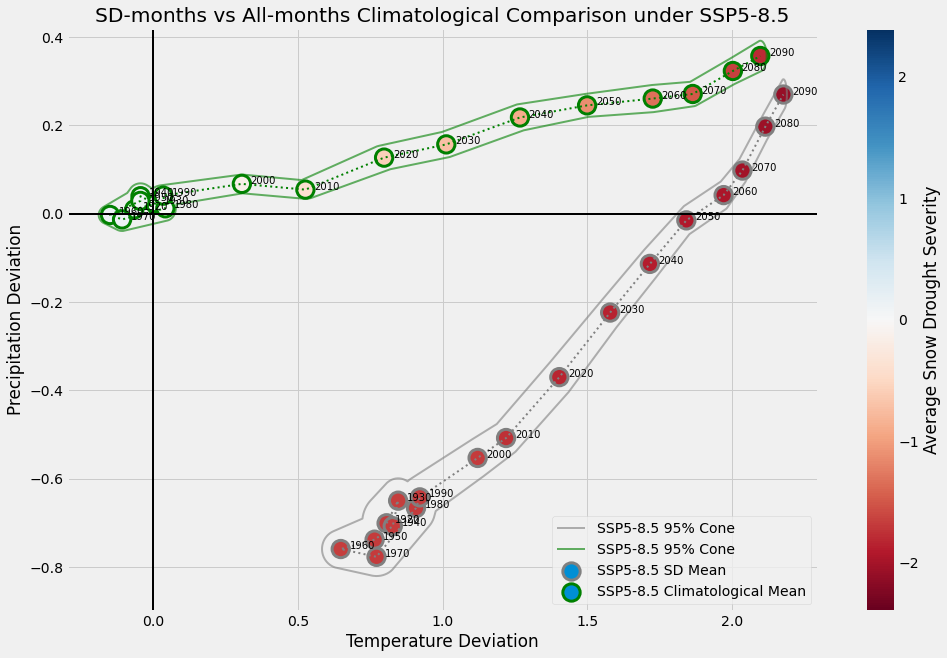

In [83]:
# make phase diagram 
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
drought_cm = matplotlib.cm.get_cmap('RdBu')

# def add_cone(poly, fig = fig, color:str='gray'):
#     px, py = poly.exterior.xy
#     cone = plt.plot(px, py, color=color, alpha =0.6, linewidth=2, label="RCP 4.5 95% Cone")
#     return cone

######### RCP8.5 ##########
# scatter and dotted line for RCP 8.5
plt.plot(temp_mean85,prec_mean85, color='grey', linestyle='dotted', linewidth=2)
im = plt.scatter(temp_mean85, prec_mean85, c=snow_mean85, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='gray', linewidths=3, label="SSP5-8.5 SD Mean")

# add annotations for RCP 8.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    plt.annotate(txt, (temp_mean85[i]+0.03, prec_mean85[i]), fontsize=10)
    
# add CIs for RCP 8.5
px, py = cone_85.exterior.xy
plt.plot(px, py, color='gray', alpha =0.6, linewidth=2, label="SSP5-8.5 95% Cone")


######## RCP 4.5 #########
# plt.plot(temp_mean45,prec_mean45, color='grey', linestyle='dotted', linewidth=2)
# im = plt.scatter(temp_mean45, prec_mean45, c=snow_mean45, s=300, cmap=drought_cm, 
#             vmin=-2.4, vmax=2.4, edgecolors='gray', linewidths=3, label="SSP2-4.5 SD Mean")

# # add annotations for RCP 4.5
# decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
# dec_start = [dec[0] for dec in decades]
# for i, txt in enumerate(dec_start):
#     plt.annotate(txt, (temp_mean45[i]+0.03, prec_mean45[i]), fontsize=10)
    
# # add CIs for RCP 4.5
# px245, py245 = cone_45.exterior.xy
# plt.plot(px245, py245, color='gray', alpha =0.6, linewidth=2, label="SSP2-4.5 95% Cone")




# add climatological data
# scatter and dotted line for RCP 8.5
plt.plot(clim_temp_m85,clim_prec_m85, color='green', linestyle='dotted', linewidth=2)
plt.scatter(clim_temp_m85, clim_prec_m85, c=clim_snow_m85, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='green', linewidths=3, label="SSP5-8.5 Climatological Mean")

# add annotations for RCP 8.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    plt.annotate(txt, (clim_temp_m85[i]+0.03, clim_prec_m85[i]), fontsize=10)
    

# add CIs for RCP 8.5
px, py = clim_cone_85.exterior.xy
plt.plot(px, py, color='green', alpha =0.6, linewidth=2, label="SSP5-8.5 95% Cone")

# ######## RCP 4.5 #########
# plt.plot(clim_temp_m45,clim_prec_m45, color='green', linestyle='dotted', linewidth=2)
# im = plt.scatter(clim_temp_m45, clim_prec_m45, c=clim_snow_m45, s=300, cmap=drought_cm, 
#             vmin=-2.4, vmax=2.4, edgecolors='green', linewidths=3, label="SSP2-4.5 Climatological Mean")

# # add annotations for RCP 4.5
# decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
# dec_start = [dec[0] for dec in decades]
# for i, txt in enumerate(dec_start):
#     plt.annotate(txt, (temp_mean45[i]+0.03, prec_mean45[i]), fontsize=10)
    

# # add CIs for RCP 4.5
# px245, py245 = clim_cone_45.exterior.xy
# plt.plot(px245, py245, color='green', alpha =0.6, linewidth=2, label="SSP2-4.5 95% Cone")





# set axes so comparison is identical
plt.xlim(-0.3,2.3)
plt.ylim(-0.9, 0.42)

plt.axvline(0, color='k', linewidth=2)
plt.axhline(0, color='k', linewidth=2)
plt.xlabel("Temperature Deviation")
plt.ylabel("Precipitation Deviation")
plt.title("SD-months vs All-months Climatological Comparison under SSP5-8.5")
plt.legend()
plt.colorbar(im, label="Average Snow Drought Severity");
plt.savefig("/home/Julian.Schmitt/plots/Drought_1.3_andclim_phase_diagram_ssp5_8.5.png", dpi=250)

## Get TOE for RCP 8.5 trend
Take spatial intersect of CI cones and find which year is the first which doesn't overlap

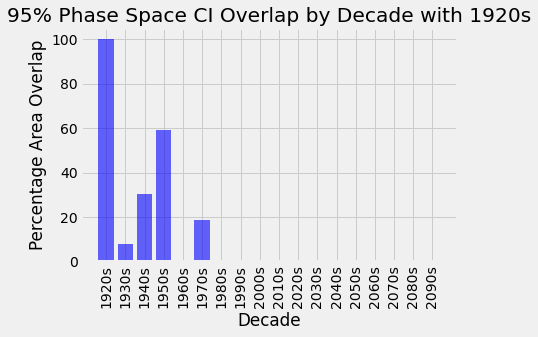

In [136]:
# get areas 
poly_num = 0
areas = []
for polygon in ps:
    areas.append(ps[poly_num].intersection(polygon).area/ ps[poly_num].area * 100)
    
# plot intersect areas
plt.bar(range(18), areas, color='blue', alpha=0.6)
plt.xticks(ticks=range(18), labels=[f"{str(d[0])}s" for d in decades], rotation=90);
plt.title("95% Phase Space CI Overlap by Decade with 1920s")
plt.ylabel("Percentage Area Overlap")
plt.xlabel("Decade");